# IMDA Dataset processing

In [1]:
import os
import re
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore')

## load results

In [2]:
llm_result_df = pd.read_excel("../data/session3/IMDA_original3_V3b_gpt_0908_ra.xlsx")
print(llm_result_df.shape)
llm_result_df[['file_name','x_min', 'text','GPT4o']].head()

(175317, 14)


,file_name,x_min,text,GPT4o
0,app_0302_3604_phnd_cc-hol.TextGrid,0.00000,call three holiday,0.0
1,app_0302_0018_phnd_cc-hol.TextGrid,3.12927,hi good afternoon this is lily from A B C trav...,0.3
2,app_0302_3604_phnd_cc-hol.TextGrid,8.22110,hi (uh) lily (uh) I'm joyce here (ppb) (um) I'...,0.5
3,app_0302_3604_phnd_cc-hol.TextGrid,21.06413,(um) I'm looking into (um) a package to either...,0.3
4,app_0302_0018_phnd_cc-hol.TextGrid,30.81900,hi miss joy we do have a package to korea and ...,0.5


In [3]:
# merge rule-based results : Textblob, VADER, Stanza
files_and_versions = [
    ("../data/session3/IMDA_original3_FILTERED_78K_sentiment_0908-v2.csv", 2),
    ("../data/session3/IMDA_original3_FILTERED_78K_sentiment_0908-v3.csv", 3),
    ("../data/session3/IMDA_original3_FILTERED_78K_sentiment_0908-v5.csv", 5),
    ("../data/session3/IMDA_original3_FILTERED_78K_sentiment_0908-v6.csv", 6),
    ("../data/session3/IMDA_original3_FILTERED_78K_sentiment_0908-v8.csv", 8),    
]

dataframes = []

for file, version in files_and_versions:
    df = pd.read_csv(file)
    df = df.drop(columns=['Unnamed: 0'])
    df = df.fillna(0)
    df = df.drop(columns=['session_id', 'speaker_id', 'speaker_type', 'dialog_type',
                         'x_max', 'text', 'cleaned_text_for_sentiment', 'word_count',
                          'duration', 'qualified_for_sentiment','processed_text'])
    # Rename sentiment-related columns
    df = df.rename(columns={
        'sentiment_label_VADER': f'V-{version}',
        'sentiment_label_TextBlob': f'T-{version}',
        'sentiment_label_Stanza': f'S-{version}'
    })
    
    # Append the DataFrame to the list
    dataframes.append(df)

# Merge the DataFrames on 'file_name', 'speaker_id', 'x_min'
# Use reduce to merge multiple DataFrames iteratively
from functools import reduce

rule_based_results_df = reduce(lambda left, right: pd.merge(left, right, on=['file_name', 'x_min'], how='inner'), dataframes)

# Display the first few rows of the merged DataFrame
print(rule_based_results_df.shape)
rule_based_results_df[['file_name','x_min', 'V-2','T-3','S-5','S-6', 'S-8']].head()
#['file_name', 'x_min', 'V-2', 'T-2', 'S-2', 'V-3', 'T-3', 'S-3', 'V-5','T-5', 'S-5', 'V-6', 'T-6', 'S-6', 'V-8', 'T-8', 'S-8']

(78737, 17)


,file_name,x_min,V-2,T-3,S-5,S-6,S-8
0,app_0302_0018_phnd_cc-hol.TextGrid,3.12927,0.6808,0.7,0.0,0,0.0
1,app_0302_3604_phnd_cc-hol.TextGrid,8.22110,0.6597,0.0,0.0,0,0.0
2,app_0302_3604_phnd_cc-hol.TextGrid,21.06413,0.0000,0.0,0.0,0,0.0
3,app_0302_0018_phnd_cc-hol.TextGrid,30.81900,0.4939,0.8,0.0,0,0.0
4,app_0302_0018_phnd_cc-hol.TextGrid,48.24106,0.2263,0.5,0.0,0,0.0


In [4]:
merged_df = pd.merge(llm_result_df, rule_based_results_df, on=['file_name', 'x_min'], how='right')
print(merged_df.shape)
merged_df[['file_name','x_min', 'text','GPT4o','V-2','T-3','S-5','S-6', 'S-8']].head()

(79729, 29)


,file_name,x_min,text,GPT4o,V-2,T-3,S-5,S-6,S-8
0,app_0302_0018_phnd_cc-hol.TextGrid,3.12927,hi good afternoon this is lily from A B C trav...,0.30,0.6808,0.7,0.0,0,0.0
1,app_0302_3604_phnd_cc-hol.TextGrid,8.22110,hi (uh) lily (uh) I'm joyce here (ppb) (um) I'...,0.50,0.6597,0.0,0.0,0,0.0
2,app_0302_3604_phnd_cc-hol.TextGrid,21.06413,(um) I'm looking into (um) a package to either...,0.30,0.0000,0.0,0.0,0,0.0
3,app_0302_0018_phnd_cc-hol.TextGrid,30.81900,hi miss joy we do have a package to korea and ...,0.50,0.4939,0.8,0.0,0,0.0
4,app_0302_0018_phnd_cc-hol.TextGrid,48.24106,eighth july okay (ppb) so may I know how many ...,0.15,0.2263,0.5,0.0,0,0.0


In [5]:
merged_df[[ 'GPT4o', 'V-2', 'V-3', 'V-5', 'V-6', 'V-8', 
               'T-2','T-3', 'T-5','T-6','T-8', 
               'S-3', 'S-2','S-5','S-6','S-8']].corr().round(3)

,GPT4o,V-2,V-3,V-5,V-6,V-8,T-2,T-3,T-5,T-6,T-8,S-3,S-2,S-5,S-6,S-8
GPT4o,1.000,0.251,0.217,0.217,0.252,0.218,0.142,0.125,0.125,0.147,0.125,0.149,0.173,0.154,0.172,0.152
V-2,0.251,1.000,0.903,0.901,0.984,0.901,0.393,0.383,0.383,0.395,0.383,0.210,0.286,0.201,0.226,0.202
V-3,0.217,0.903,1.000,0.998,0.902,0.997,0.382,0.419,0.419,0.381,0.419,0.223,0.242,0.213,0.178,0.214
V-5,0.217,0.901,0.998,1.000,0.901,0.999,0.382,0.418,0.418,0.381,0.418,0.224,0.243,0.214,0.179,0.215
V-6,0.252,0.984,0.902,0.901,1.000,0.900,0.391,0.382,0.382,0.394,0.382,0.210,0.287,0.203,0.231,0.203
V-8,0.218,0.901,0.997,0.999,0.900,1.000,0.382,0.418,0.418,0.381,0.418,0.223,0.242,0.214,0.178,0.215
T-2,0.142,0.393,0.382,0.382,0.391,0.382,1.000,0.898,0.898,0.982,0.898,0.228,0.242,0.235,0.215,0.235
T-3,0.125,0.383,0.419,0.418,0.382,0.418,0.898,1.000,0.999,0.902,0.999,0.233,0.217,0.241,0.192,0.241
T-5,0.125,0.383,0.419,0.418,0.382,0.418,0.898,0.999,1.000,0.902,1.000,0.232,0.217,0.241,0.193,0.241
T-6,0.147,0.395,0.381,0.381,0.394,0.381,0.982,0.902,0.902,1.000,0.902,0.226,0.236,0.233,0.214,0.233


In [6]:
# Extracting the VADER, TextBlob, and Stanza columns for comparison
'''CONFIGURABLE'''
vader_columns = ['V-2', 'V-3'] # [col for col in merged_df.columns if col.startswith('V-')]
textblob_columns = ['T-2', 'T-3'] # [col for col in merged_df.columns if col.startswith('T-')]
stanza_columns = ['S-2', 'S-3', 'S-5' ,'S-6','S-8']  #[col for col in merged_df.columns if col.startswith('S-')]

# Define the sentiment classification function based on the provided thresholds
def classify_sentiment_vader(score):
    if -0.05 <= score <= 0.5:
        return 'neutral'
    elif score > 0.5:
        return 'positive'
    else:
        return 'negative'

def classify_sentiment_textblob(score):
    if -0.05 <= score <= 0.3:
        return 'neutral'
    elif score > 0.3:
        return 'positive'
    else:
        return 'negative'

def classify_sentiment_stanza(score):
    # Since no specific threshold is provided, let's assume a default for demonstration
    if -0.05 <= score <= 0.05:
        return 'neutral'
    elif score > 0.05:
        return 'positive'
    else:
        return 'negative'

# Apply classification to each sentiment analysis method
for col in vader_columns:
    merged_df[f'{col}_sentiment'] = merged_df[col].apply(classify_sentiment_vader)

for col in textblob_columns:
    merged_df[f'{col}_sentiment'] = merged_df[col].apply(classify_sentiment_textblob)

for col in stanza_columns:
    merged_df[f'{col}_sentiment'] = merged_df[col].apply(classify_sentiment_stanza)


### Plots

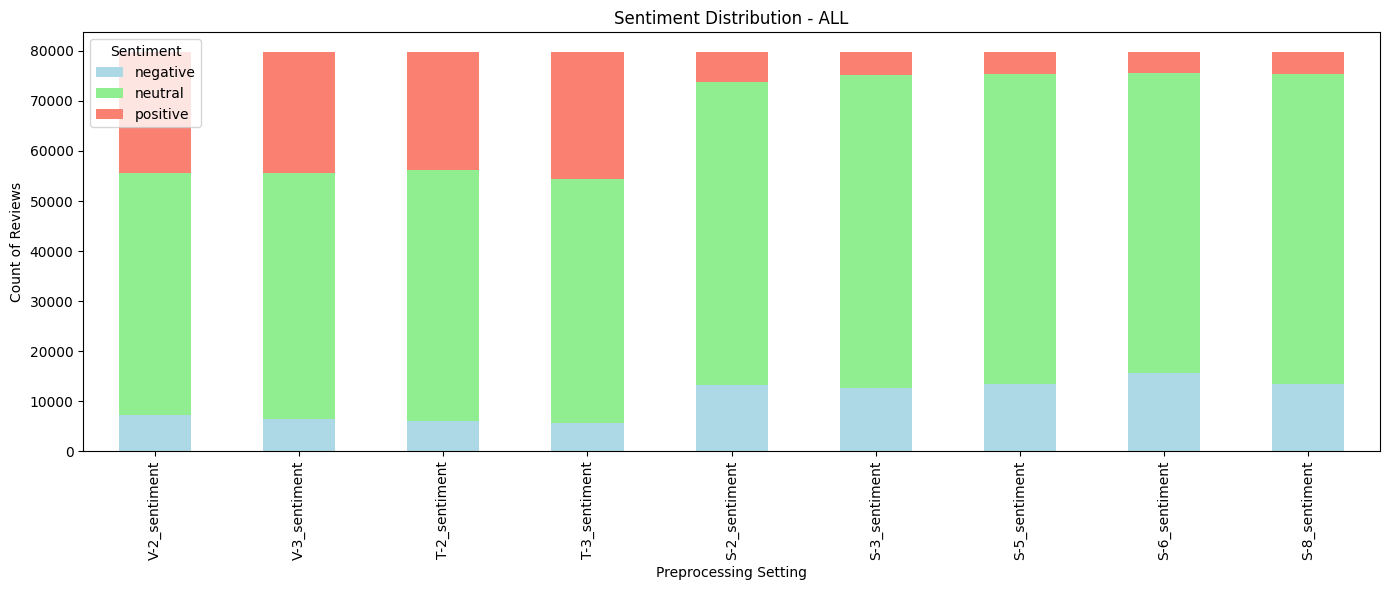

In [7]:
import matplotlib.pyplot as plt
# Calculate the sentiment distribution for each method
distribution = merged_df[[f'{col}_sentiment' for col in vader_columns +textblob_columns + stanza_columns ]].apply(pd.Series.value_counts)

# Plot the sentiment distribution for VADER
distribution.T.plot(kind='bar', stacked=True, figsize=(14, 6), color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Sentiment Distribution - ALL')
plt.xlabel('Preprocessing Setting')
plt.ylabel('Count of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()



## Rule based voting

In [8]:
# Map the sentiment labels to integers
label_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
# Apply classification to each sentiment analysis method
for col in vader_columns + textblob_columns + stanza_columns:
    merged_df[f'{col}_vote'] = merged_df[col + '_sentiment'].map(label_mapping)

vote_columns = [col for col in merged_df.columns if col.endswith('_vote')]
# Calculate the total votes for each review
merged_df['sum_score'] = merged_df[vote_columns].sum(axis=1)

In [9]:
# Calculate the maximum frequency and identify the corresponding sentiment
def determine_max_sentiment(pos_count, neg_count, neu_count):
    max_frequency = max(pos_count, neg_count, neu_count)
    
    if max_frequency == pos_count and pos_count > max(neg_count, neu_count):
        return 'positive', max_frequency
    elif max_frequency == neg_count and neg_count > max(pos_count, neu_count):
        return 'negative', max_frequency
    elif max_frequency == neu_count and neu_count > max(neg_count, pos_count):
        return 'neutral', max_frequency
    else:
        return 'tie', max_frequency

# Function to calculate the highest frequency of a value in a row
def calculate_highest_frequency(row):
    # Count the occurrences of each vote
    pos_count = sum(row[col] == 1 for col in vote_columns)
    neg_count = sum(row[col] == -1 for col in vote_columns)
    neu_count = sum(row[col] == 0 for col in vote_columns)
    
    max_sentiment, max_frequency = determine_max_sentiment(pos_count, neg_count, neu_count)
    return max_sentiment, max_frequency


merged_df[['rule_based_label', 'max_agreement_votes']] = merged_df.apply(
    lambda row: calculate_highest_frequency(row), axis=1, result_type='expand'
)

merged_df[['rule_based_label', 'max_agreement_votes']].head()

,rule_based_label,max_agreement_votes
0,neutral,5
1,neutral,7
2,neutral,9
3,neutral,7
4,neutral,7


In [10]:
'''CONFIGURABLE'''
merged_df['others_agree_with_each_other'] = merged_df['max_agreement_votes']>= 6 
merged_df['others_agree_with_each_other'].value_counts()
merged_df['vader_avg'] = merged_df[vader_columns].mean(axis=1)
merged_df['textblob_avg'] = merged_df[textblob_columns].mean(axis=1)
merged_df['stanza_avg'] = merged_df[stanza_columns].mean(axis=1)

merged_df['rule_based_score'] = merged_df[['vader_avg', 'textblob_avg', 'stanza_avg']].mean(axis=1)

columns_to_be_dropped = ['V-2', 'T-2', 'S-2', 'V-3','T-3', 'S-3', 'V-5', 'T-5', 'S-5', 'V-6', 'T-6', 'S-6', 
'V-8', 'T-8','S-8','V-2_sentiment', 'V-3_sentiment', 'T-2_sentiment', 'T-3_sentiment', 'S-2_sentiment',
'S-3_sentiment', 'S-5_sentiment', 'S-6_sentiment', 'S-8_sentiment','V-2_vote', 'V-3_vote', 'T-2_vote', 'T-3_vote', 'S-2_vote', 'S-3_vote',
'S-5_vote', 'S-6_vote', 'S-8_vote']
merged_df = merged_df.drop(columns = columns_to_be_dropped)

## LLM (OpenAI GPT 4o mini

In [11]:
merged_df['GPT4o'].value_counts()

GPT4o
 0.30    27964
 0.00    18952
 0.50    17090
 0.70     6043
 0.15     3485
-0.30     3307
-0.15     1263
-0.50      933
-0.70      241
 1.00       14
Name: count, dtype: int64

In [12]:
'''CONFIGURABLE'''
def classify_sentiment_GPT4o(score):
    if -0.1 <= score <= 0.3:
        return 'neutral'
    elif score > 0.35:
        return 'positive'
    else:
        return 'negative'

merged_df['GPT4o_label'] = merged_df['GPT4o'].apply(classify_sentiment_GPT4o)
merged_df['GPT4o_label'].value_counts()

GPT4o_label
neutral     50401
positive    23147
negative     6181
Name: count, dtype: int64

In [13]:
merged_df['others_agree_with_LLM'] = merged_df['rule_based_label']==merged_df['GPT4o_label']
merged_df['others_agree_with_LLM'].value_counts()

others_agree_with_LLM
True     48364
False    31365
Name: count, dtype: int64

In [14]:
merged_df['others_agree_with_each_other'].value_counts()

others_agree_with_each_other
True     58765
False    20964
Name: count, dtype: int64

In [15]:
# Function to calculate final sentiment score
def calculate_final_sentiment(row): 
    if not row['others_agree_with_each_other']:
        # If others don't agree with each other
        final_score = row['GPT4o'] * 1.0  # GPT4o 1, others 0
    else:
        # If others agree with each other
        if row['others_agree_with_LLM']:
            final_score = row['GPT4o'] * 0.7 + row['rule_based_score'] * 0.3  # GPT4o 0.7, others 0.3
        else:
            final_score = row['GPT4o'] * 0.8 + row['rule_based_score'] * 0.2  # GPT4o 0.8, others 0.2
    return final_score

# Apply the function to calculate the final sentiment score
merged_df['final_sentiment_score'] = merged_df.apply(calculate_final_sentiment, axis=1)

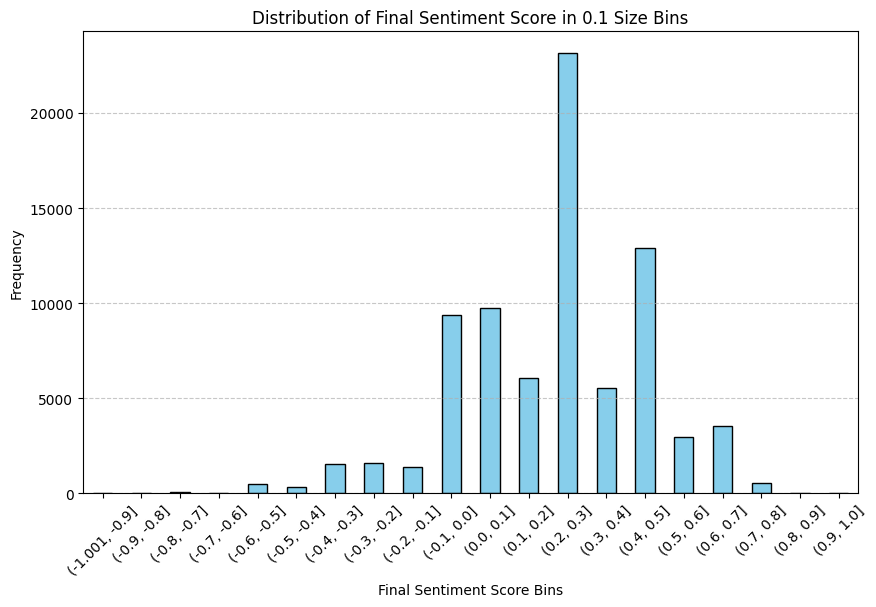

final_sentiment_score
(-1.001, -0.9]        0
(-0.9, -0.8]          0
(-0.8, -0.7]         75
(-0.7, -0.6]         46
(-0.6, -0.5]        488
(-0.5, -0.4]        359
(-0.4, -0.3]       1543
(-0.3, -0.2]       1608
(-0.2, -0.1]       1365
(-0.1, 0.0]        9389
(0.0, 0.1]         9750
(0.1, 0.2]         6054
(0.2, 0.3]        23134
(0.3, 0.4]         5536
(0.4, 0.5]        12879
(0.5, 0.6]         2939
(0.6, 0.7]         3552
(0.7, 0.8]          562
(0.8, 0.9]            2
(0.9, 1.0]           11
Name: count, dtype: int64


In [16]:
import matplotlib.pyplot as plt

# Calculate binning of 'final_sentiment_score' in bins of size 0.1
bin_counts = pd.cut(merged_df['final_sentiment_score'], bins=[i/10 for i in range(-10, 11)], include_lowest=True).value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Final Sentiment Score in 0.1 Size Bins')
plt.xlabel('Final Sentiment Score Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display the bin counts
print(bin_counts)

In [17]:
def classify_sentiment_final(score):
    # Since no specific threshold is provided, let's assume a default for demonstration
    if -0.05 <= score <= 0.3:
        return 'neutral'
    elif score > 0.1:
        return 'positive'
    else:
        return 'negative'
merged_df['final_sentiment_label'] = merged_df['final_sentiment_score'].apply(classify_sentiment_final)
merged_df['final_sentiment_label'].value_counts()

final_sentiment_label
neutral     47281
positive    25481
negative     6967
Name: count, dtype: int64

In [18]:
merged_df[merged_df['others_agree_with_LLM']==True]['final_sentiment_label'].value_counts()

final_sentiment_label
neutral     41093
positive     5413
negative     1858
Name: count, dtype: int64

In [19]:
agreed_df = merged_df[merged_df['others_agree_with_LLM']==True]
agreed_df[agreed_df['final_sentiment_label']=='negative'].sort_values(by='final_sentiment_score')['cleaned_text_for_sentiment'].head().values

array(['the penalty will be depends on the circumstances so (uh) the worst case will be confiscate your house',
       'all of the workers in the outlet and unfortunately I m one of the unfortunate one',
       'clearly trying to find work but I can t seem to so (um) is there any way that (uh) I could possibly apply with the with your ministry in terms of some (uh) financial assistance',
       'she can t walk for the time being (uh) because seven eleven have to stand (ppb) (um) the whole day so how to stand now the leg injured already some more it is (err) there s a cast on it right now',
       'so I guess that medical those medical treatment usually be very expensive and will be taxing for her especially even though she just got a job'],
      dtype=object)

In [20]:
merged_df.columns

Index(['file_name', 'session_id', 'speaker_id', 'speaker_type', 'dialog_type',
       'x_min', 'x_max', 'text', 'cleaned_text_for_sentiment', 'word_count',
       'duration', 'qualified_for_sentiment', 'GPT4o', 'explanation',
       'sum_score', 'rule_based_label', 'max_agreement_votes',
       'others_agree_with_each_other', 'vader_avg', 'textblob_avg',
       'stanza_avg', 'rule_based_score', 'GPT4o_label',
       'others_agree_with_LLM', 'final_sentiment_score',
       'final_sentiment_label'],
      dtype='object')

In [21]:
merged_df.to_csv("../data/session3/IMDA_session3_merged_rule_n_GPT4o.csv",index=False)

In [22]:
# merged_df = merged_df.assign(Speed=lambda x: x['word_count']/x['duration'])
# merged_df_filtered = merged_df[(merged_df['duration']<8) & (merged_df['Speed']>1.8)]
# merged_df_filtered['final_sentiment_label'].value_counts()

In [23]:
merged_df.head()

,file_name,session_id,speaker_id,speaker_type,dialog_type,x_min,x_max,text,cleaned_text_for_sentiment,word_count,...,max_agreement_votes,others_agree_with_each_other,vader_avg,textblob_avg,stanza_avg,rule_based_score,GPT4o_label,others_agree_with_LLM,final_sentiment_score,final_sentiment_label
0,app_0302_0018_phnd_cc-hol.TextGrid,302.0,18.0,agent,hol,3.12927,8.50931,hi good afternoon this is lily from A B C trav...,hi good afternoon this is lily from A B C trav...,17.0,...,5,False,0.6808,0.7,0.0,0.460267,neutral,True,0.30000,neutral
1,app_0302_3604_phnd_cc-hol.TextGrid,302.0,3604.0,client,hol,8.22110,21.06413,hi (uh) lily (uh) I'm joyce here (ppb) (um) I'...,hi (uh) lily (uh) I m joyce here (ppb) (um) I ...,20.0,...,7,True,0.6597,0.0,0.0,0.219900,positive,False,0.44398,positive
2,app_0302_3604_phnd_cc-hol.TextGrid,302.0,3604.0,client,hol,21.06413,30.21838,(um) I'm looking into (um) a package to either...,(um) I m looking into (um) a package to either...,15.0,...,9,True,0.0000,0.0,0.0,0.000000,neutral,True,0.21000,neutral
3,app_0302_0018_phnd_cc-hol.TextGrid,302.0,18.0,agent,hol,30.81900,42.98125,hi miss joy we do have a package to korea and ...,hi miss joy we do have a package to korea and ...,24.0,...,7,True,0.4939,0.8,0.0,0.431300,positive,False,0.48626,positive
4,app_0302_0018_phnd_cc-hol.TextGrid,302.0,18.0,agent,hol,48.24106,54.42762,eighth july okay (ppb) so may I know how many ...,eighth july okay (ppb) so may I know how many ...,13.0,...,7,True,0.2263,0.5,0.0,0.242100,neutral,True,0.17763,neutral
